In [23]:
# !pip3 install talos
# !pip3 install --upgrade --no-deps --force-reinstall git+https://github.com/autonomio/talos
# !pip3 install Keras
# !pip3 install kerasplotlib --no-deps
# !pip3 install wrangle --no-deps

In [24]:
# Basic libs
import array as array
import glob
import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime, timedelta
from pathlib import Path
from pandas.plotting import scatter_matrix

# Plot libs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.patches as patches

# Model libs
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import LSTM as LSTM_keras
from numpy.random import seed
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json

# Optimization Lib
import keras.metrics as metrics
# from talos import Scan, Reporting
from os import listdir

# To get reproducible results:
seed_value = 1
import os

## Initialize the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Libs to set the random value 
import random
import numpy as np
import tensorflow as tf

In [25]:
# Number of minutes to aggregate the data
MINUTES = 1

# Where the test data start
TEST_INIT_DATE = datetime(2021, 2, 1).date()

# Size of the look back
LOOK_BACK = 12

# The csv station ("santa_elena" or "hawkesworth_bridge")
STATION = "hawkesworth_bridge"

# Factor to multiply by MAPE in classification step
FACTOR = 10

## Reproducible Results

In [26]:
# Set the random state to "1" to get reproducible results
def reset_random_seeds():
    
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ["PYTHONHASHSEED"] = str(1)
    
    # 2. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(1)
    
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(1)
    
    # 4. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(1)

## Pre-Processing

In [27]:
# Combines the csvs creating a DataFrame with all data (regression)
def read_data(path):
    df_all = None

    # Show all csv ending with _wtlv1 in all dirs inside this path
    for f in Path(path).rglob('*_wtlv1*.csv'):
        print(f)
    
        # Ignores other spreadsheets that are not STATION
        if not STATION in str(f):
            continue
    
        # Get the filename, without the path
        station = os.path.basename(f).split('_wtlv1')[0]
    
        # datetime and update_at are combined as one date column
        _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
        _df['station'] = station
    
        if df_all is None:
            df_all = _df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)
        
    # Remove updated_at and variable_id columns 
    df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)
    
    # Remove duplicates rows (by datetime)
    df_all.drop_duplicates(subset=["datetime"], keep="last", inplace=True)
      
    # Sort the dataframe and remove the index
    df_all.set_index("datetime", inplace=True)
    df_all.sort_index(inplace=True)
    df_all.reset_index(inplace=True)
        
    return(df_all)

In [28]:
# Read only the "anomaly_name" csv (classification)
def read_anomaly_data(path, anomaly_name):
    data = pd.read_csv("{}/artificial-{}-anomaly.csv".format(path, anomaly_name))
    
    # Convert the string dates to datetime
    data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    
    return(data)

In [29]:
# Groups the data by a number of minutes
def group_by(raw_data, minutes):
    
    # Group by minutes, aggregating with "sum"
    df_aggregated = raw_data.groupby([pd.Grouper(key="datetime", freq=f"{minutes}min"), "station_id"]).sum()
    df_aggregated.reset_index(inplace=True)
    
     # Define "datetime" as index
    df_aggregated = df_aggregated.set_index('datetime')
    
    return(df_aggregated)

In [30]:
# Gets the "measured" time series and transform it in a supervised problem
## If the serie is: [1, 2, 3, 4, 5, 6] and the look_back is 3
## The data: [1, 2, 3], [2, 3, 4], [3, 4, 5] 
## The labels: 4, 5 and 6
def create_supervised_data(original_data, look_back):

    new_data = original_data.copy()

    # Organize the data with look back
    ## Features (remove first NaN columns)
    for shift in range(look_back, 0, -1):
        new_data[f"shift_{look_back-shift}"] = original_data["measured"].shift(periods=shift).iloc[look_back:]

    ## Labels
    new_data["labels"] = original_data["measured"]
    new_data = new_data.iloc[look_back:]
    
    return(new_data)

In [31]:
# Get shift columns and labels column 
def get_columns(look_back):
    x_columns = ["shift_{}".format(shift) for shift in range(look_back)]
    y_columns = "labels"
    
    return(x_columns, y_columns)

In [32]:
# Split the data into train and test set. Train: data before the "day". Test: data after the "day"
def split_dataset(df, day, look_back):
    
    # Get columns of interest
    x_columns, y_column = get_columns(look_back)
        
    df = df.reset_index()
    
    # Get train data
    df_slice = df[df.datetime.dt.date < day] 
    X_train = df_slice[x_columns]
    y_train = df_slice[y_column]
    
    # Get test data
    df_slice = df[df.datetime.dt.date >= day] 
    X_test = df_slice[x_columns]
    y_test = df_slice[y_column]
    
    print("  Train:")
    print("    - X_train: {}".format(X_train.shape))
    print("    - y_train: {}".format(y_train.shape))
    
    print("\n  Test:")
    print("    - X_test: {}".format(X_test.shape))
    print("    - y_test: {}".format(y_test.shape))
    
    # Put in a dictionary
    train = { "data": X_train, "labels": y_train }
    test = { "data": X_test, "labels": y_test }
    
    return(train, test)

## Plots Functions

In [33]:
# Funtion that plots the expected vs predicted values
def plot_predicted_vs_expected(predicted, expected, rmse, all_datetime, start, end):

    # Get the datetime of test set
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Predicted", marker="s")
    ax.plot(x_axis, d2, label="Expected", marker="s")

    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")

    # Shows RMSE
    plt.gcf().text(-0.01, -0.01, "RMSE = {:.4}".format(rmse), fontsize=14) 

    # Adds rotation in x axis values
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [34]:
# Function to plot the scatter plot (predicted x expected)
def scatter_plot(predicted, expected, start, end):

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d2 = pd.DataFrame({"Expected": np.asarray(expected[start:end])})

    # Define the plot
    plt.figure(1)

    ax = plt.subplot()
    plt.scatter(x=d1.values, y=d2.values)

    # Adds subtitle
    ax.set_ylabel("Expected")
    ax.set_xlabel("Predicted")

    # Adds title and plot it
    plt.title("LSTM Model: Expected VS Predicted")
    plt.show()

In [35]:
# Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies
def plot_predicted_vs_expected_vs_mav(predicted, measured, mav, all_datetime, start, end, anomaly_type):

    # Get the datetime of test of
    x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
    x_axis = x_axis[start:end].strftime("%d %b %H:%M")

    # Defines the figure size
    sns.set(rc={'figure.figsize':(11, 10)})

    # Build the dataframes that will be plot
    d1 = pd.DataFrame({"Measured": np.asarray(measured[start:end])})
    d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
    d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

    # Creates the plot
    fig, ax = plt.subplots()
    ax.plot(x_axis, d1, label="Measured", marker="s")
    ax.plot(x_axis, d2, label="Predicted", marker="s")
    ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")
    
    # Draw the retangles
    for index in range(start, end):
        
        # Gets the real measured and the anomaly value (from mav array)
        measure = np.asarray(measured)[index]
        anomaly = np.asarray(mav)[index]

        # If the mesuares are different, than an anomaly exists
        if(measure != anomaly):
            
            # If the anomaly is above the measure on plot
            if(anomaly > measure):
                
                if(anomaly_type == "sv"):
                    padding = 0.01
                else:
                    padding = 0.3
                
                # Define the size of the rectangle (y axis)
                top = abs(anomaly) + padding
                bottom = measure - padding
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
            # If the anomaly is below the measure on plot
            else:
                
                # Define the size of the rectangle (y axis)
                top = measure + 0.3
                bottom = anomaly - 0.3
                size = top - bottom
                
                # Creates the rectangle
                rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            
    # Adds subtitle
    ax.legend()
    ax.set_ylabel("Measured")
    ax.set_xlabel("Time")
    
    plt.xticks(rotation=70)

    # Adds title and plot it
    plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
    plt.show()

## Aggregation Optimization

In [36]:
# Divides the train set into train and validation
def get_validation_set(train, limit):
    
    # Select the last "limit" data
    start = int(len(train["data"])) - limit
    val_data = train["data"].iloc[start:]
    val_labels = train["labels"].iloc[start:]
    
    # Select the first train_size - "limit" data
    new_train_data = train["data"].iloc[:start]
    new_train_labels = train["labels"].iloc[:start]
    
    print("\n  Validation:")
    print("    - X_val: {}".format(val_data.shape))
    print("    - y_val: {}".format(val_labels.shape))
    
    new_train = { "data": new_train_data, "labels": new_train_labels }
    val = { "data": val_data, "labels": val_labels}
    
    return(new_train, val)

In [37]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_aggregation_interval(anomaly_name, val_size):
    
    print("Find Best Aggregation Interval:")

    minutes = [1]
    minutes.extend(list(range(5, 61, 5)))
    minutes.extend(list(range(60, 24* 60 + 1, 60)))
    
    raw_data = read_data("s")
    
    experiments = []
    for minute in minutes:
        print(f"\n\nMinute: {minute}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, LOOK_BACK)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, LOOK_BACK)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(LOOK_BACK, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((minute, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nMinutes:   RMSE:")
    for minute, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(minute, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Look Back Optimization

In [38]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_look_back(anomaly_name, val_size, minute):
    
    print("Find Best Look Back Value:")

    look_back_values = [*range(1, 21)]
#     look_back_values.extend([*range(15, 301, 5)])
    print(look_back_values)
    
    raw_data = read_data("s")
    
    experiments = []
    for look_back in look_back_values:
        print(f"\nLook Back: {look_back}\n")
        
        # ------------------------------ Pre-Processing ----------------------------------
        
        data = group_by(raw_data, minute)
        
        data = create_supervised_data(data, look_back)
        
        no_val_train, test = split_dataset(data, TEST_INIT_DATE, look_back)
        
        train, validation = get_validation_set(no_val_train, val_size)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Creates the model
        lstm = LSTM()

        # Use the default hyperparameters
        lstm.init(look_back, len(train["labels"]))
        
        # Compile 
        lstm.build()

        # Evaluates the model with the validation set 
        ## Compute the start time
        start = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n  Time:")
        print("    - Start: {}\n".format(current_time))
        
        ## Evaluate
        results = lstm.evaluate_model(train, validation)
        
        ## Compute the end time
        stop = time.time()
        current_time = datetime.now().strftime("%H:%M:%S")
        print("\n     - Stop: {}".format(current_time))
        print("     - Runtime: {} minutes ({} secs)".format((stop-start) // 60.0, int(stop-start)))
        
        experiments.append((look_back, results["overall_score"]))
    
        # Show the results
        print("     - Aggregation Level: {} minutes".format(minute))
        print("     - Look Back: {}".format(look_back))
        print("     - Overall RMSE: {:.4} ".format(results["overall_score"]))     
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by RMSE
    sorted_results = sorted(experiments, key=lambda tup: tup[1], reverse=False)

    print("\nLook Back:   RMSE:")
    for look_back, rmse in sorted_results:
        print("{:6}   =>   {:.4}".format(look_back, rmse))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------
    
# ----------------------------------------------------------------------------------------

## Model Class: LSTM (2 Layers)

In [39]:
# LSTM Model
class LSTM:
    
    # --------------------------------------------------------------------------------
    
    # Initialize the hyperparameters. Sets to default value if some param is "None"
    def init(self, look_back, n_samples, params=None):
        
        # To get reproductible results
        reset_random_seeds()
        
        # If params is None, set all the hyperparams to None (to get default values)
        if(params == None):

            # Default:
            params = {
                        # First Layer
                        "units_1": 50,
                        "activation_1": "sigmoid",
                        "recurrent_activation_1": "relu",
                        "use_bias_1": True,
                        "unit_forget_bias_1": True,
                        "dropout_1": 0.0,
                        "recurrent_dropout_1": 0.0,
                        "return_sequences_1": True,
                        "return_state_1": False,
                        "go_backwards_1": False,
                        "stateful_1": 0.0,
                        "unroll_1": False,

                        # Second Layer
                        "units_2": 50,
                        "activation_2": "sigmoid",
                        "recurrent_activation_2": "relu",
                        "use_bias_2": True,
                        "unit_forget_bias_2": True,
                        "dropout_2": 0.0,
                        "recurrent_dropout_2": 0.0,
                        "return_sequences_2": False,
                        "return_state_2": False,
                        "go_backwards_2": False,
                        "stateful_2": 0.0,
                        "unroll_2": False,

                        # General
                        "epochs": 5,
                        "batch_size": 1,
                        "loss": "mean_squared_error",
                        "optimizer": "adam"
                    }

        # Model Hyperparameters (first layer)
        self.units_1 = params["units_1"]
        self.activation_1 = params["activation_1"]
        self.recurrent_activation_1 = params["recurrent_activation_1"]
        self.use_bias_1 = params["use_bias_1"]
        self.unit_forget_bias_1 = params["unit_forget_bias_1"]
        self.dropout_1 = params["dropout_1"]
        self.recurrent_dropout_1 = params["recurrent_dropout_1"]
        self.return_sequences_1 = params["return_sequences_1"]
        self.return_state_1 = params["return_state_1"]
        self.go_backwards_1 = params["go_backwards_1"]
        self.stateful_1 = params["stateful_1"]
        self.unroll_1 = params["unroll_1"]
        
        # Model Hyperparameters (second layer)
        self.units_2 = params["units_2"]
        self.activation_2 = params["activation_2"]
        self.recurrent_activation_2 = params["recurrent_activation_2"]
        self.use_bias_2 = params["use_bias_2"]
        self.unit_forget_bias_2 = params["unit_forget_bias_2"]
        self.dropout_2 = params["dropout_2"]
        self.recurrent_dropout_2 = params["recurrent_dropout_2"]
        self.return_sequences_2 = params["return_sequences_2"]
        self.return_state_2 = params["return_state_2"]
        self.go_backwards_2 = params["go_backwards_2"]
        self.stateful_2 = params["stateful_2"]
        self.unroll_2 = params["unroll_2"]
        
        # General
        self.epochs = params["epochs"]
        self.batch_size = params["batch_size"]
        self.loss = params["loss"]
        self.optimizer = params["optimizer"]
        
        # Dimensions
        self.n_timesteps = look_back
        self.n_features = 1
        self.n_outputs = 1
        self.n_samples = n_samples
        
        # Other params
        self.model = None
        self.model_fit = None
    # --------------------------------------------------------------------------------
        
    # Create and compile the model
    def build(self):
    
        # Create the model
        self.model = Sequential()
        
        # First Layer
        self.model.add(LSTM_keras(units = self.units_1,
                                  batch_input_shape=(self.batch_size, self.n_timesteps, self.n_features),
                                  activation = self.activation_1,
                                  recurrent_activation = self.recurrent_activation_1,
                                  use_bias = self.use_bias_1,
                                  unit_forget_bias = self.unit_forget_bias_1,
                                  dropout = self.dropout_1,
                                  recurrent_dropout = self.recurrent_dropout_1,
                                  return_sequences = self.return_sequences_1,
                                  return_state = self.return_state_1,
                                  go_backwards = self.go_backwards_1,
                                  stateful = self.stateful_1,
                                  unroll = self.unroll_1))
        
        # Second Layer
        self.model.add(LSTM_keras(units = self.units_2,
                                  activation = self.activation_2,
                                  recurrent_activation = self.recurrent_activation_2,
                                  use_bias = self.use_bias_2,
                                  unit_forget_bias = self.unit_forget_bias_2,
                                  dropout = self.dropout_2,
                                  recurrent_dropout = self.recurrent_dropout_2,
                                  return_sequences = self.return_sequences_2,
                                  return_state = self.return_state_2,
                                  go_backwards = self.go_backwards_2,
                                  stateful = self.stateful_2,
                                  unroll = self.unroll_2))
        
        # Output Layer
        self.model.add(Dense(self.n_outputs))
    
        # Compile the model
        self.model.compile(loss=self.loss, optimizer=self.optimizer)
    # --------------------------------------------------------------------------------
    
    # Flatten the data and train the model
    def train(self, train):

        # Flatten data
        train_data = train["data"].to_numpy()
        train_data = train_data.reshape(train_data.shape[0], self.n_timesteps, self.n_features)

        train_labels = train["labels"].to_numpy()
        train_labels = train_labels.reshape(train_labels.shape[0], 1)

        # Train
        self.model_fit = self.model.fit(train_data, train_labels, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
    # --------------------------------------------------------------------------------    
    
    # Flatten the data and predict one example
    def predict(self, example):
           
        # Flatten data
        data = np.array(example)
        data = data.reshape((1, data.shape[0], 1))
       
        # forescast the next week
        prediction = self.model.predict(data, verbose=0)
        
        # We only want the vector forecast
        prediction = float(prediction[0][0])
    
        return(prediction)
    # --------------------------------------------------------------------------------
    
    # Get the RMSE per week and the overall RMSE
    def evaluate_forecasts(self, expected, predicted):
        
        # RMSE per example
        rmses = []     
        for i in range(expected.shape[0]):
            mse = mean_squared_error(np.asarray([expected[i]]), np.asarray([predicted[i]]))
            rmse = np.sqrt(mse)
            rmses.append(rmse)
            
        # Overall RMSE
        rmse_overall = expected - predicted
        rmse_overall = np.sqrt(np.mean(rmse_overall**2))
                      
        return(rmses, rmse_overall)
    # --------------------------------------------------------------------------------
    
    # Train and predict the entire test set
    def evaluate_model(self, train, test):
           
        # Create and train the model
        self.train(train)
    
        # List of predictions
        predictions = list()
    
        for i in range(len(test["labels"])):
            
            print("\nExample {} / {}\n".format(i, len(test["labels"])))
        
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Predict the entire test set
    def evaluate_model_no_train(self, train, test):
           
        # List of predictions
        predictions = list()
    # --------------------------------------------------------------------------------
    
        # ------------------------------ Progress Bar --------------------------------
        
        initial_increment = int(len(test["labels"]) // 100.0)
        increment = initial_increment
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-100s] %d%%" % ('='*0, 0))
        sys.stdout.flush()
        
        j = 1
        for i in range(len(test["labels"])):
                    
            if(i == increment):
                sys.stdout.write('\r')
                sys.stdout.write("[%-100s] %d%%" % ('='*j, j))
                sys.stdout.flush()
                increment += initial_increment
                j += 1
        # ---------------------------------------------------------------------------
                 
            # Predict one day
            example = test["data"].iloc[i, :]
            prediction = self.predict(example)
        
            # Store the predictions
            predictions.append(prediction)
        
        # Evaluate predictions for each day and overall
        predicted = np.array(predictions)
        expected = np.array(test["labels"])
        
        scores, score = self.evaluate_forecasts(expected, predicted)
        
        results = { "predicted": predicted, "expected": expected, "overall_score": score, "daily_scores": scores }
    
        return(results)
    # --------------------------------------------------------------------------------
    
    # Save the network
    def save(self, filename):
        filename_model = "{}.json".format(filename)
        filename_weights = "{}-weights.h5".format(filename)

        # Save the model
        modelJson = self.model.to_json()
        with open(filename_model, "w") as jsonFile:
            jsonFile.write(modelJson)
            
        # Save the weights
        self.model.save_weights("{}".format(filename_weights))
    # --------------------------------------------------------------------------------
    
    # Load the model and the weights
    def load(self, filename):
        
        # Load the json
        json_file = open("{}.json".format(filename, 'r'))
        loaded_model_json = json_file.read()
        json_file.close()

        loaded_model = model_from_json(loaded_model_json)

        # Load the weights into the model
        loaded_model.load_weights("{}-weights.h5".format(filename))
        print("Loaded model from disk")
        
        return(loaded_model)
    # --------------------------------------------------------------------------------
    
    # Print the hyperparameters used
    def show_hyperparameters(self):
        print("LSTM Hyperparameters:")
        print("\n  First Layer:")
        print("    - Units: {}".format(self.units_1))
        print("    - Activation: {}".format(self.activation_1))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_1))
        print("    - Use Bias: {}".format(self.use_bias_1))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_1))
        print("    - Dropout: {}".format(self.dropout_1))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_1))
        print("    - Return Sequences: {}".format(self.return_sequences_1))
        print("    - Return State: {}".format(self.return_state_1))
        print("    - Go Backwards: {}".format(self.go_backwards_1))
        print("    - Stateful: {}".format(self.stateful_1))
        print("    - Unroll: {}".format(self.unroll_1))
        
        print("\n  Second Layer:")
        print("    - Units: {}".format(self.units_2))
        print("    - Activation: {}".format(self.activation_2))
        print("    - Recurrent Activation: {}".format(self.recurrent_activation_2))
        print("    - Use Bias: {}".format(self.use_bias_2))
        print("    - Unit Forget Bias: {}".format(self.unit_forget_bias_2))
        print("    - Dropout: {}".format(self.dropout_2))
        print("    - Recurrent Dropout: {}".format(self.recurrent_dropout_2))
        print("    - Return Sequences: {}".format(self.return_sequences_2))
        print("    - Return State: {}".format(self.return_state_2))
        print("    - Go Backwards: {}".format(self.go_backwards_2))
        print("    - Stateful: {}".format(self.stateful_2))
        print("    - Unroll: {}".format(self.unroll_2))
        
        print("\n  General:")                          
        print("    - Epochs: {}".format(self.epochs))
        print("    - Batch Size: {}".format(self.batch_size))
        print("    - Loss: {}".format(self.loss))
        print("    - Optimizer: {}\n".format(self.optimizer))
        
        print("\n  Dimensions:")
        print("    - Number of Timesteps: {}".format(self.n_timesteps))
        print("    - Number of Features: {}".format(self.n_features))
        print("    - Number of Outputs: {}\n".format(self.n_outputs))
    # --------------------------------------------------------------------------------    
    
    # Show the dimensions of the network
    def show_architecture(self):
        print("\nNetwork Architecture:\n")
        self.model.summary()
        print("\n")
    # --------------------------------------------------------------------------------    
    
    # Show the overall RMSE and the daily RMSE
    def summarize_scores(self, score, scores):
        
        print("\n\nLSTM Model Scores:\n")
        print("  - Overall RMSE: {:.4}\n".format(score))
        print("  - Daily RMSEs:\n")
        print("        day   rmse")
        for index, rmse in enumerate(scores):
            print("        {}{} => {:.4}".format("0" if index < 11 else "", index+1, rmse))
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

## Optimizer Class: LSTM (Talos)

In [40]:
# # Talos Optimizer:
# class Optimizer:
    
#     # --------------------------------------------------------------------------------
    
#     # Define some params that will be used in the training function
#     def init(self, look_back, n_features, n_outputs):
#         self.n_timesteps = look_back
#         self.n_features = n_features
#         self.n_outputs = n_outputs
#         self.best_params = None
#     # --------------------------------------------------------------------------------
    
#     # Training function used in parameter optimization
#     ## Creates and trains the model
#     def fit(self, train_data, train_labels, val_data, val_labels, params):

#         print("Params:")
#         print(params)
#         print("\n")
        
#         # Create the model
#         model = Sequential()
        
#         # First Layer
#         model.add(LSTM_keras(units = params["units_1"],
#                                   batch_input_shape=(params["batch_size"], self.n_timesteps, self.n_features),
#                                   activation = params["activation_1"],
#                                   recurrent_activation = params["recurrent_activation_1"],
#                                   use_bias = params["use_bias_1"],
#                                   unit_forget_bias = params["unit_forget_bias_1"],
#                                   dropout = params["dropout_1"],
#                                   recurrent_dropout = params["recurrent_dropout_1"],
#                                   return_sequences = params["return_sequences_1"],
#                                   return_state = params["return_state_1"],
#                                   go_backwards = params["go_backwards_1"],
#                                   stateful = params["stateful_1"],
#                                   unroll = params["unroll_1"]))
        
#         # Second Layer
#         model.add(LSTM_keras(units = params["units_2"],
#                                   activation = params["activation_2"],
#                                   recurrent_activation = params["recurrent_activation_2"],
#                                   use_bias = params["use_bias_2"],
#                                   unit_forget_bias = params["unit_forget_bias_2"],
#                                   dropout = params["dropout_2"],
#                                   recurrent_dropout = params["recurrent_dropout_2"],
#                                   return_sequences = params["return_sequences_2"],
#                                   return_state = params["return_state_2"],
#                                   go_backwards = params["go_backwards_2"],
#                                   stateful = params["stateful_2"],
#                                   unroll = params["unroll_2"]))
               
#         # Output Layer
#         model.add(Dense(self.n_outputs))
    
#         # Compile the model
#         model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[metrics.mse])

#         # Fit the model
#         history = model.fit(train_data, train_labels, epochs=params["epochs"], batch_size=params["batch_size"], verbose=1, validation_split=params["validation_split"], validation_data=[val_data, val_labels])

#         return(history, model)
#     # --------------------------------------------------------------------------------
    
#     # Hyperparameters optmization function
#     def optimize(self, training_data, train_labels, look_back, params, filename, read=None):
        
#         # Samples, Time Steps e Features
#         train_data = training_data.to_numpy()
#         train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)

#         # If there is no file with the results of optimization, make the experiments
#         if(read == None):
#             scan = Scan(train_data, train_labels, params=params, experiment_name=filename, model=self.fit, fraction_limit=0.5)

#         # Finds the csv name with the results
#         experiments_file = filename + "/" + listdir(filename)[0]

#         # Store the experiments in a DataFrame
#         reporting_data = Reporting(experiments_file).data

#         # Sort the experiments by mse value
#         best_experiment = reporting_data.sort_values(by=['val_mean_squared_error']).head(1)

#         print("Best Hyperparameters:")
#         print(best_experiment)

#         # Organize the results
#         self.best_params = {
            
#                  # Dense Layer 1
#                  'units_1': int(best_experiment["units_1"].values[0]),
#                  'activation_1': best_experiment["activation_1"].values[0],
#                  'recurrent_activation_1': best_experiment["recurrent_activation_1"].values[0],
#                  'use_bias_1': best_experiment["use_bias_1"].values[0],
#                  'unit_forget_bias_1': best_experiment["unit_forget_bias_1"].values[0],
#                  'dropout_1': best_experiment["dropout_1"].values[0],
#                  'recurrent_dropout_1': best_experiment["recurrent_dropout_1"].values[0],
#                  'return_sequences_1': best_experiment["return_sequences_1"].values[0],
#                  'return_state_1': best_experiment["return_state_1"].values[0],
#                  'go_backwards_1': best_experiment["go_backwards_1"].values[0],
#                  'stateful_1': best_experiment["stateful_1"].values[0],
#                  'unroll_1': best_experiment["unroll_1"].values[0],

#                  # Dense Layer 2
#                  'units_2': int(best_experiment["units_2"].values[0]),
#                  'activation_2': best_experiment["activation_2"].values[0],
#                  'recurrent_activation_2': best_experiment["recurrent_activation_2"].values[0],
#                  'use_bias_2': best_experiment["use_bias_2"].values[0],
#                  'unit_forget_bias_2': best_experiment["unit_forget_bias_2"].values[0],
#                  'dropout_2': best_experiment["dropout_2"].values[0],
#                  'recurrent_dropout_2': best_experiment["recurrent_dropout_2"].values[0],
#                  'return_sequences_2': best_experiment["return_sequences_2"].values[0],
#                  'return_state_2': best_experiment["return_state_2"].values[0],     
#                  'go_backwards_2': best_experiment["go_backwards_2"].values[0],
#                  'stateful_2': best_experiment["stateful_2"].values[0],
#                  'unroll_2': best_experiment["unroll_2"].values[0],

#                 # Compile
#                 'optimizer': best_experiment["optimizer"].values[0],
#                 'loss': best_experiment["loss.1"].values[0],

#                 # Fit
#                 'batch_size': best_experiment["batch_size"].values[0],
#                 'epochs': best_experiment["round_epochs"].values[0],
#                 'validation_split': best_experiment["validation_split"].values[0]
#         }
#         return(self.best_params)
#     # --------------------------------------------------------------------------------
    
# # ------------------------------------------------------------------------------------

## Classification (Classes and Functions)

In [41]:
# MAPE calc of all predictions
def get_MAPE(predicted, expected):
    mape = np.mean(np.abs((expected - predicted) / expected))

    return(mape)

In [65]:
# After getting the regression, the next step is use a threshold based classifier
class Classifier:
    
    # --------------------------------------------------------------------------------
    
    exp_classes = None
    pred_classes = None
    mav = None
    misses = []
    # --------------------------------------------------------------------------------
    
    # Set some variables
    def init(self):
        self.exp_classes = None
        self.pred_classes = None
        self.mav = None
        self.misses = []
    # --------------------------------------------------------------------------------
    
    # Get mav data (measure + anomaly data)
    def get_mav_data(self, predicted, raw_data):
    
        # Size of test set
        last_test_values = predicted.shape[0]
        mav = np.where(pd.isna(raw_data["anomaly_value"]), raw_data["measured"], raw_data["anomaly_value"])
        mav = mav[-last_test_values:]
        self.mav = mav
        
        return(mav)
    # --------------------------------------------------------------------------------
    
    # Get the expected classes
    def get_expected_classes(self, expected, mav=None):
        
        # Stored inside the class
        if(mav == None):
            mav = self.mav
        
        exp_classes = []
        for index, result in enumerate(expected):
            
            # If it's equal, than it is a normal data
            if(result == mav[index]):
                exp_classes.append(0)
                
            # Otherwise, it's an anomaly data
            else:
                exp_classes.append(1)
                
        self.exp_classes = exp_classes
       
        return(exp_classes)
    # --------------------------------------------------------------------------------
    
    # Make the classification based on MAPE calc
    def get_classification(self, predicted, limit, mav=None):
        
        # Stored inside the class
        if(mav is None):
            mav = self.mav
    
        classification = []

        for index, prediction in enumerate(predicted):

            # Calculates the MAPE
            mape = np.abs((mav[index] - prediction) / mav[index])

            # MAPE is greater than limit: it is an anomaly
            if(mape > limit):

                # Indicates that the example is an anomaly
                classification.append(1)

            # Otherwise, it is a normal data
            else:

                # Indicates that the example is not an anomaly
                classification.append(0)

        self.pred_classes = classification
        
        return(classification)
    # --------------------------------------------------------------------------------
    
    # Function to define the expected data
    def set_expected_classes(self, labels):
        self.exp_classes = labels.tolist()
    # --------------------------------------------------------------------------------
    
    # Calculate the accuracy, precision, recall and f1 score of the classification
    def get_metrics(self, anomaly_type, expected=None, predicted=None):
        
        if(expected == None):
            expected = self.exp_classes
            
        if(predicted == None):
            predicted = self.pred_classes

        TP = 0 # True Positive
        TN = 0 # True Negative
        FP = 0 # False Positive
        FN = 0 # False Negative

        classification = []

        for index, prediction in enumerate(predicted):

            # If it is right
            if(expected[index] == prediction):

                # If it is an anomaly
                if(prediction == 1):
                    TP += 1

                # If it is a normal data
                else:
                    TN += 1

            # Otherwise, it is wrong
            else:
                
                # Get the index where the error appear
                self.misses.append(index)

                # If it is an anomaly
                if(prediction == 1):
                    FP += 1

                # If it is a normal data
                else:
                    FN += 1

        if(anomaly_type == "s+sv+sd"):
            print("Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "sv+sd"):
            print("Stationary Value (SV) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sd"):
            print("Spike (S) and Sensor Displacement (SD):")
            
        elif(anomaly_type == "s+sv"):
            print("Spike (S) and Stationary Value (SV):")
            
        elif(anomaly_type == "sv"):
            print("Stationary Value (SV):")
            
        elif(anomaly_type == "sd"):
            print("Sensor Displacement (SD):")
        
        else:
            print("Spike (S):")

        print("\n  General:")
        print("    - TP: {}".format(TP))
        print("    - TN: {}".format(TN))
        print("    - FP: {}".format(FP))
        print("    - FN: {}".format(FN))
        print("    - Hits: {}".format(TP + TN))
        print("    - Misses: {}".format(FN + FP))
        print("    - Total (hits + misses): {}".format(TP + TN + FP + FN))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * ((precision * recall) / (precision + recall))

        print("\n  Metrics:")
        print("    - Accuracy: {:.4}%".format(accuracy * 100.0))
        print("    - Precision: {:.4}%".format(precision * 100.0))
        print("    - Recall: {:.4}%".format(recall * 100.0))
        print("    - F1-Score: {:.4}%".format(f1_score * 100.0))

        metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score}

        return(metrics)
    # --------------------------------------------------------------------------------
    
    # Funtion that plots the expected vs predicted vs mav values and draw a rectangle on anomalies (just FN)
    def show_the_wrongs_predictions(self, predicted, expected, all_datetime, miss_index, anomaly_type, mav=None):
        
        if(len(self.misses) == 0):
            print("\n\nThe classification hit all the predictions\n\n")
            return
        
        if(mav == None):
            mav = self.mav
            
        start = self.misses[miss_index] - 10
        end = self.misses[miss_index] + 10
        
        start = 0 if(start < 0) else start
        end = len(predicted) if(end > len(predicted)) else end

        # Get the datetime of test of
        x_axis = all_datetime[all_datetime.date >= TEST_INIT_DATE]
        x_axis = x_axis[start:end].strftime("%d %b %H:%M")

        # Defines the figure size
        sns.set(rc={'figure.figsize':(11, 10)})

        # Build the dataframes that will be plot
        d1 = pd.DataFrame({"Measured": np.asarray(expected[start:end])})
        d2 = pd.DataFrame({"Predicted" : np.asarray(predicted[start:end])})
        d3 = pd.DataFrame({"Measured and Anomalies": np.asarray(mav[start:end])})

        # Creates the plot
        fig, ax = plt.subplots()
        ax.plot(x_axis, d1, label="Measured", marker="s")
        ax.plot(x_axis, d2, label="Predicted", marker="s")
        ax.plot(x_axis, d3, label="Measured and Anomalies", marker="s")

        # Draw the retangles
        for index in range(start, end):

            # Gets the real measured and the anomaly value (from mav array)
            measure = np.asarray(expected)[index]
            anomaly = np.asarray(mav)[index]

            # If the mesuares are different, than an anomaly exists
            if(measure != anomaly):

                # If the anomaly is above the measure on plot
                if(anomaly > measure):

                    if(anomaly_type == "sv"):
                        padding = 0.01
                    else:
                        padding = 0.3

                    # Define the size of the rectangle (y axis)
                    top = abs(anomaly) + padding
                    bottom = measure - padding
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, measure - padding), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

                # If the anomaly is below the measure on plot
                else:

                    # Define the size of the rectangle (y axis)
                    top = measure + 0.3
                    bottom = anomaly - 0.3
                    size = top - bottom

                    # Creates the rectangle
                    if(index == start+10):
                        rect = patches.Rectangle((index - 1 - start, anomaly - 0.3), 2, size, linewidth=1,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)

        # Adds subtitle
        ax.legend()
        ax.set_ylabel("Measured")
        ax.set_xlabel("Time")

        plt.xticks(rotation=70)

        # Adds title and plot it
        plt.title("LSTM Model: Predicted VS Measured VS Measured and Anomalies")
        plt.show()
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

# Main - Regression

In [43]:
# Function that read the test data (with anomalies)
def read_input(filename):
    data = pd.read_csv(filename)
    data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    
    return(data)

## Pre-Processing

In [44]:
# Read all data
input_data = read_input("input.csv")

# Transform into a supervised problem
data_sup = create_supervised_data(input_data, LOOK_BACK)

# Divide into train and test set
train, test = split_dataset(data_sup, TEST_INIT_DATE, LOOK_BACK)

  Train:
    - X_train: (63585, 12)
    - y_train: (63585,)

  Test:
    - X_test: (8665, 12)
    - y_test: (8665,)


In [45]:
# # Read "Spike" data
# anomaly_type = "s"
# raw_data = read_anomaly_data("./csvs/all_data", anomaly_type)

# print("\nRaw Data:")
# print(" - Start Date: {}".format(raw_data["datetime"].min())) # 26/06
# print(" - End Date: {}".format(raw_data["datetime"].max())) # 30/11

# # Group by "MINUTES (1)"
# data = group_by(raw_data, MINUTES)

# print("\nData Shape:")
# print(data.shape)

# # Shift data using the "LOOK_BACK" (12)
# data_sup = create_supervised_data(data, LOOK_BACK)

# # Split data into train and test set
# print("\nDataset:")
# train, test = split_dataset(data_sup, TEST_INIT_DATE, LOOK_BACK)

# data_sup.head(30)

## Model: LSTM

In [46]:
# Best params found by the Talos Optimization
best_params = {
                 'units_1': 50,
                 'activation_1': 'sigmoid',
                 'recurrent_activation_1': 'relu',
                 'use_bias_1': True,
                 'unit_forget_bias_1': True,
                 'dropout_1': 0.0,
                 'recurrent_dropout_1': 0.0,
                 'return_sequences_1': True,
                 'return_state_1': False,
                 'go_backwards_1': False,
                 'stateful_1': False,
                 'unroll_1': False,
                 'units_2': 50,
                 'activation_2': 'sigmoid',
                 'recurrent_activation_2': 'relu',
                 'use_bias_2': True,
                 'unit_forget_bias_2': True,
                 'dropout_2': 0.0,
                 'recurrent_dropout_2': 0.0,
                 'return_sequences_2': False,
                 'return_state_2': False,
                 'go_backwards_2': False,
                 'stateful_2': False,
                 'unroll_2': False,
                 'optimizer': 'adam',
                 'loss': 'mean_squared_error',
                 'batch_size': 1,
                 'epochs': 80,
                 'validation_split': 0.1
}

# Loads the trained model
filename = "saved_models/LSTM-measured-regression-model-3-anomalies"

# Create, init, load and evaluate the LSTM
lstm = LSTM()
lstm.init(LOOK_BACK, len(train["labels"]), best_params)
lstm.model = lstm.load(filename)
lstm.show_architecture()
results = lstm.evaluate_model_no_train(train, test)

# If it needs to retrain
# lstm = LSTM()
# lstm.init(LOOK_BACK, len(train["labels"]), best_params)
# lstm.build()
# results = lstm.evaluate_model(train, test)
# lstm.save(filename)

# Show the results
lstm.summarize_scores(results["overall_score"], results["daily_scores"])

Epoch 1/80
63585/63585 [==============================] - 260s 4ms/step - loss: 0.0504
Epoch 2/80
63585/63585 [==============================] - 254s 4ms/step - loss: 0.0280
Epoch 3/80
63585/63585 [==============================] - 254s 4ms/step - loss: 0.0272
Epoch 4/80
63585/63585 [==============================] - 254s 4ms/step - loss: 0.0271
Epoch 5/80
63585/63585 [==============================] - 254s 4ms/step - loss: 0.0268
Epoch 6/80
63585/63585 [==============================] - 255s 4ms/step - loss: 0.0257
Epoch 7/80
63585/63585 [==============================] - 255s 4ms/step - loss: 0.0257
Epoch 8/80
63585/63585 [==============================] - 255s 4ms/step - loss: 0.0261
Epoch 9/80
63585/63585 [==============================] - 256s 4ms/step - loss: 0.0246
Epoch 10/80
63585/63585 [==============================] - 256s 4ms/step - loss: 0.0253
Epoch 11/80
63585/63585 [==============================] - 256s 4ms/step - loss: 0.0251
Epoch 12/80
63585/63585 [================


Example 61 / 8665


Example 62 / 8665


Example 63 / 8665


Example 64 / 8665


Example 65 / 8665


Example 66 / 8665


Example 67 / 8665


Example 68 / 8665


Example 69 / 8665


Example 70 / 8665


Example 71 / 8665


Example 72 / 8665


Example 73 / 8665


Example 74 / 8665


Example 75 / 8665


Example 76 / 8665


Example 77 / 8665


Example 78 / 8665


Example 79 / 8665


Example 80 / 8665


Example 81 / 8665


Example 82 / 8665


Example 83 / 8665


Example 84 / 8665


Example 85 / 8665


Example 86 / 8665


Example 87 / 8665


Example 88 / 8665


Example 89 / 8665


Example 90 / 8665


Example 91 / 8665


Example 92 / 8665


Example 93 / 8665


Example 94 / 8665


Example 95 / 8665


Example 96 / 8665


Example 97 / 8665


Example 98 / 8665


Example 99 / 8665


Example 100 / 8665


Example 101 / 8665


Example 102 / 8665


Example 103 / 8665


Example 104 / 8665


Example 105 / 8665


Example 106 / 8665


Example 107 / 8665


Example 108 / 8665


Example 109 / 8665


Example 1


Example 457 / 8665


Example 458 / 8665


Example 459 / 8665


Example 460 / 8665


Example 461 / 8665


Example 462 / 8665


Example 463 / 8665


Example 464 / 8665


Example 465 / 8665


Example 466 / 8665


Example 467 / 8665


Example 468 / 8665


Example 469 / 8665


Example 470 / 8665


Example 471 / 8665


Example 472 / 8665


Example 473 / 8665


Example 474 / 8665


Example 475 / 8665


Example 476 / 8665


Example 477 / 8665


Example 478 / 8665


Example 479 / 8665


Example 480 / 8665


Example 481 / 8665


Example 482 / 8665


Example 483 / 8665


Example 484 / 8665


Example 485 / 8665


Example 486 / 8665


Example 487 / 8665


Example 488 / 8665


Example 489 / 8665


Example 490 / 8665


Example 491 / 8665


Example 492 / 8665


Example 493 / 8665


Example 494 / 8665


Example 495 / 8665


Example 496 / 8665


Example 497 / 8665


Example 498 / 8665


Example 499 / 8665


Example 500 / 8665


Example 501 / 8665


Example 502 / 8665


Example 503 / 8665


Example 504 


Example 853 / 8665


Example 854 / 8665


Example 855 / 8665


Example 856 / 8665


Example 857 / 8665


Example 858 / 8665


Example 859 / 8665


Example 860 / 8665


Example 861 / 8665


Example 862 / 8665


Example 863 / 8665


Example 864 / 8665


Example 865 / 8665


Example 866 / 8665


Example 867 / 8665


Example 868 / 8665


Example 869 / 8665


Example 870 / 8665


Example 871 / 8665


Example 872 / 8665


Example 873 / 8665


Example 874 / 8665


Example 875 / 8665


Example 876 / 8665


Example 877 / 8665


Example 878 / 8665


Example 879 / 8665


Example 880 / 8665


Example 881 / 8665


Example 882 / 8665


Example 883 / 8665


Example 884 / 8665


Example 885 / 8665


Example 886 / 8665


Example 887 / 8665


Example 888 / 8665


Example 889 / 8665


Example 890 / 8665


Example 891 / 8665


Example 892 / 8665


Example 893 / 8665


Example 894 / 8665


Example 895 / 8665


Example 896 / 8665


Example 897 / 8665


Example 898 / 8665


Example 899 / 8665


Example 900 


Example 1238 / 8665


Example 1239 / 8665


Example 1240 / 8665


Example 1241 / 8665


Example 1242 / 8665


Example 1243 / 8665


Example 1244 / 8665


Example 1245 / 8665


Example 1246 / 8665


Example 1247 / 8665


Example 1248 / 8665


Example 1249 / 8665


Example 1250 / 8665


Example 1251 / 8665


Example 1252 / 8665


Example 1253 / 8665


Example 1254 / 8665


Example 1255 / 8665


Example 1256 / 8665


Example 1257 / 8665


Example 1258 / 8665


Example 1259 / 8665


Example 1260 / 8665


Example 1261 / 8665


Example 1262 / 8665


Example 1263 / 8665


Example 1264 / 8665


Example 1265 / 8665


Example 1266 / 8665


Example 1267 / 8665


Example 1268 / 8665


Example 1269 / 8665


Example 1270 / 8665


Example 1271 / 8665


Example 1272 / 8665


Example 1273 / 8665


Example 1274 / 8665


Example 1275 / 8665


Example 1276 / 8665


Example 1277 / 8665


Example 1278 / 8665


Example 1279 / 8665


Example 1280 / 8665


Example 1281 / 8665


Example 1282 / 8665


Example 1


Example 1611 / 8665


Example 1612 / 8665


Example 1613 / 8665


Example 1614 / 8665


Example 1615 / 8665


Example 1616 / 8665


Example 1617 / 8665


Example 1618 / 8665


Example 1619 / 8665


Example 1620 / 8665


Example 1621 / 8665


Example 1622 / 8665


Example 1623 / 8665


Example 1624 / 8665


Example 1625 / 8665


Example 1626 / 8665


Example 1627 / 8665


Example 1628 / 8665


Example 1629 / 8665


Example 1630 / 8665


Example 1631 / 8665


Example 1632 / 8665


Example 1633 / 8665


Example 1634 / 8665


Example 1635 / 8665


Example 1636 / 8665


Example 1637 / 8665


Example 1638 / 8665


Example 1639 / 8665


Example 1640 / 8665


Example 1641 / 8665


Example 1642 / 8665


Example 1643 / 8665


Example 1644 / 8665


Example 1645 / 8665


Example 1646 / 8665


Example 1647 / 8665


Example 1648 / 8665


Example 1649 / 8665


Example 1650 / 8665


Example 1651 / 8665


Example 1652 / 8665


Example 1653 / 8665


Example 1654 / 8665


Example 1655 / 8665


Example 1


Example 1987 / 8665


Example 1988 / 8665


Example 1989 / 8665


Example 1990 / 8665


Example 1991 / 8665


Example 1992 / 8665


Example 1993 / 8665


Example 1994 / 8665


Example 1995 / 8665


Example 1996 / 8665


Example 1997 / 8665


Example 1998 / 8665


Example 1999 / 8665


Example 2000 / 8665


Example 2001 / 8665


Example 2002 / 8665


Example 2003 / 8665


Example 2004 / 8665


Example 2005 / 8665


Example 2006 / 8665


Example 2007 / 8665


Example 2008 / 8665


Example 2009 / 8665


Example 2010 / 8665


Example 2011 / 8665


Example 2012 / 8665


Example 2013 / 8665


Example 2014 / 8665


Example 2015 / 8665


Example 2016 / 8665


Example 2017 / 8665


Example 2018 / 8665


Example 2019 / 8665


Example 2020 / 8665


Example 2021 / 8665


Example 2022 / 8665


Example 2023 / 8665


Example 2024 / 8665


Example 2025 / 8665


Example 2026 / 8665


Example 2027 / 8665


Example 2028 / 8665


Example 2029 / 8665


Example 2030 / 8665


Example 2031 / 8665


Example 2


Example 2365 / 8665


Example 2366 / 8665


Example 2367 / 8665


Example 2368 / 8665


Example 2369 / 8665


Example 2370 / 8665


Example 2371 / 8665


Example 2372 / 8665


Example 2373 / 8665


Example 2374 / 8665


Example 2375 / 8665


Example 2376 / 8665


Example 2377 / 8665


Example 2378 / 8665


Example 2379 / 8665


Example 2380 / 8665


Example 2381 / 8665


Example 2382 / 8665


Example 2383 / 8665


Example 2384 / 8665


Example 2385 / 8665


Example 2386 / 8665


Example 2387 / 8665


Example 2388 / 8665


Example 2389 / 8665


Example 2390 / 8665


Example 2391 / 8665


Example 2392 / 8665


Example 2393 / 8665


Example 2394 / 8665


Example 2395 / 8665


Example 2396 / 8665


Example 2397 / 8665


Example 2398 / 8665


Example 2399 / 8665


Example 2400 / 8665


Example 2401 / 8665


Example 2402 / 8665


Example 2403 / 8665


Example 2404 / 8665


Example 2405 / 8665


Example 2406 / 8665


Example 2407 / 8665


Example 2408 / 8665


Example 2409 / 8665


Example 2


Example 2743 / 8665


Example 2744 / 8665


Example 2745 / 8665


Example 2746 / 8665


Example 2747 / 8665


Example 2748 / 8665


Example 2749 / 8665


Example 2750 / 8665


Example 2751 / 8665


Example 2752 / 8665


Example 2753 / 8665


Example 2754 / 8665


Example 2755 / 8665


Example 2756 / 8665


Example 2757 / 8665


Example 2758 / 8665


Example 2759 / 8665


Example 2760 / 8665


Example 2761 / 8665


Example 2762 / 8665


Example 2763 / 8665


Example 2764 / 8665


Example 2765 / 8665


Example 2766 / 8665


Example 2767 / 8665


Example 2768 / 8665


Example 2769 / 8665


Example 2770 / 8665


Example 2771 / 8665


Example 2772 / 8665


Example 2773 / 8665


Example 2774 / 8665


Example 2775 / 8665


Example 2776 / 8665


Example 2777 / 8665


Example 2778 / 8665


Example 2779 / 8665


Example 2780 / 8665


Example 2781 / 8665


Example 2782 / 8665


Example 2783 / 8665


Example 2784 / 8665


Example 2785 / 8665


Example 2786 / 8665


Example 2787 / 8665


Example 2


Example 3120 / 8665


Example 3121 / 8665


Example 3122 / 8665


Example 3123 / 8665


Example 3124 / 8665


Example 3125 / 8665


Example 3126 / 8665


Example 3127 / 8665


Example 3128 / 8665


Example 3129 / 8665


Example 3130 / 8665


Example 3131 / 8665


Example 3132 / 8665


Example 3133 / 8665


Example 3134 / 8665


Example 3135 / 8665


Example 3136 / 8665


Example 3137 / 8665


Example 3138 / 8665


Example 3139 / 8665


Example 3140 / 8665


Example 3141 / 8665


Example 3142 / 8665


Example 3143 / 8665


Example 3144 / 8665


Example 3145 / 8665


Example 3146 / 8665


Example 3147 / 8665


Example 3148 / 8665


Example 3149 / 8665


Example 3150 / 8665


Example 3151 / 8665


Example 3152 / 8665


Example 3153 / 8665


Example 3154 / 8665


Example 3155 / 8665


Example 3156 / 8665


Example 3157 / 8665


Example 3158 / 8665


Example 3159 / 8665


Example 3160 / 8665


Example 3161 / 8665


Example 3162 / 8665


Example 3163 / 8665


Example 3164 / 8665


Example 3


Example 3493 / 8665


Example 3494 / 8665


Example 3495 / 8665


Example 3496 / 8665


Example 3497 / 8665


Example 3498 / 8665


Example 3499 / 8665


Example 3500 / 8665


Example 3501 / 8665


Example 3502 / 8665


Example 3503 / 8665


Example 3504 / 8665


Example 3505 / 8665


Example 3506 / 8665


Example 3507 / 8665


Example 3508 / 8665


Example 3509 / 8665


Example 3510 / 8665


Example 3511 / 8665


Example 3512 / 8665


Example 3513 / 8665


Example 3514 / 8665


Example 3515 / 8665


Example 3516 / 8665


Example 3517 / 8665


Example 3518 / 8665


Example 3519 / 8665


Example 3520 / 8665


Example 3521 / 8665


Example 3522 / 8665


Example 3523 / 8665


Example 3524 / 8665


Example 3525 / 8665


Example 3526 / 8665


Example 3527 / 8665


Example 3528 / 8665


Example 3529 / 8665


Example 3530 / 8665


Example 3531 / 8665


Example 3532 / 8665


Example 3533 / 8665


Example 3534 / 8665


Example 3535 / 8665


Example 3536 / 8665


Example 3537 / 8665


Example 3


Example 3871 / 8665


Example 3872 / 8665


Example 3873 / 8665


Example 3874 / 8665


Example 3875 / 8665


Example 3876 / 8665


Example 3877 / 8665


Example 3878 / 8665


Example 3879 / 8665


Example 3880 / 8665


Example 3881 / 8665


Example 3882 / 8665


Example 3883 / 8665


Example 3884 / 8665


Example 3885 / 8665


Example 3886 / 8665


Example 3887 / 8665


Example 3888 / 8665


Example 3889 / 8665


Example 3890 / 8665


Example 3891 / 8665


Example 3892 / 8665


Example 3893 / 8665


Example 3894 / 8665


Example 3895 / 8665


Example 3896 / 8665


Example 3897 / 8665


Example 3898 / 8665


Example 3899 / 8665


Example 3900 / 8665


Example 3901 / 8665


Example 3902 / 8665


Example 3903 / 8665


Example 3904 / 8665


Example 3905 / 8665


Example 3906 / 8665


Example 3907 / 8665


Example 3908 / 8665


Example 3909 / 8665


Example 3910 / 8665


Example 3911 / 8665


Example 3912 / 8665


Example 3913 / 8665


Example 3914 / 8665


Example 3915 / 8665


Example 3


Example 4247 / 8665


Example 4248 / 8665


Example 4249 / 8665


Example 4250 / 8665


Example 4251 / 8665


Example 4252 / 8665


Example 4253 / 8665


Example 4254 / 8665


Example 4255 / 8665


Example 4256 / 8665


Example 4257 / 8665


Example 4258 / 8665


Example 4259 / 8665


Example 4260 / 8665


Example 4261 / 8665


Example 4262 / 8665


Example 4263 / 8665


Example 4264 / 8665


Example 4265 / 8665


Example 4266 / 8665


Example 4267 / 8665


Example 4268 / 8665


Example 4269 / 8665


Example 4270 / 8665


Example 4271 / 8665


Example 4272 / 8665


Example 4273 / 8665


Example 4274 / 8665


Example 4275 / 8665


Example 4276 / 8665


Example 4277 / 8665


Example 4278 / 8665


Example 4279 / 8665


Example 4280 / 8665


Example 4281 / 8665


Example 4282 / 8665


Example 4283 / 8665


Example 4284 / 8665


Example 4285 / 8665


Example 4286 / 8665


Example 4287 / 8665


Example 4288 / 8665


Example 4289 / 8665


Example 4290 / 8665


Example 4291 / 8665


Example 4


Example 4620 / 8665


Example 4621 / 8665


Example 4622 / 8665


Example 4623 / 8665


Example 4624 / 8665


Example 4625 / 8665


Example 4626 / 8665


Example 4627 / 8665


Example 4628 / 8665


Example 4629 / 8665


Example 4630 / 8665


Example 4631 / 8665


Example 4632 / 8665


Example 4633 / 8665


Example 4634 / 8665


Example 4635 / 8665


Example 4636 / 8665


Example 4637 / 8665


Example 4638 / 8665


Example 4639 / 8665


Example 4640 / 8665


Example 4641 / 8665


Example 4642 / 8665


Example 4643 / 8665


Example 4644 / 8665


Example 4645 / 8665


Example 4646 / 8665


Example 4647 / 8665


Example 4648 / 8665


Example 4649 / 8665


Example 4650 / 8665


Example 4651 / 8665


Example 4652 / 8665


Example 4653 / 8665


Example 4654 / 8665


Example 4655 / 8665


Example 4656 / 8665


Example 4657 / 8665


Example 4658 / 8665


Example 4659 / 8665


Example 4660 / 8665


Example 4661 / 8665


Example 4662 / 8665


Example 4663 / 8665


Example 4664 / 8665


Example 4


Example 4994 / 8665


Example 4995 / 8665


Example 4996 / 8665


Example 4997 / 8665


Example 4998 / 8665


Example 4999 / 8665


Example 5000 / 8665


Example 5001 / 8665


Example 5002 / 8665


Example 5003 / 8665


Example 5004 / 8665


Example 5005 / 8665


Example 5006 / 8665


Example 5007 / 8665


Example 5008 / 8665


Example 5009 / 8665


Example 5010 / 8665


Example 5011 / 8665


Example 5012 / 8665


Example 5013 / 8665


Example 5014 / 8665


Example 5015 / 8665


Example 5016 / 8665


Example 5017 / 8665


Example 5018 / 8665


Example 5019 / 8665


Example 5020 / 8665


Example 5021 / 8665


Example 5022 / 8665


Example 5023 / 8665


Example 5024 / 8665


Example 5025 / 8665


Example 5026 / 8665


Example 5027 / 8665


Example 5028 / 8665


Example 5029 / 8665


Example 5030 / 8665


Example 5031 / 8665


Example 5032 / 8665


Example 5033 / 8665


Example 5034 / 8665


Example 5035 / 8665


Example 5036 / 8665


Example 5037 / 8665


Example 5038 / 8665


Example 5


Example 5372 / 8665


Example 5373 / 8665


Example 5374 / 8665


Example 5375 / 8665


Example 5376 / 8665


Example 5377 / 8665


Example 5378 / 8665


Example 5379 / 8665


Example 5380 / 8665


Example 5381 / 8665


Example 5382 / 8665


Example 5383 / 8665


Example 5384 / 8665


Example 5385 / 8665


Example 5386 / 8665


Example 5387 / 8665


Example 5388 / 8665


Example 5389 / 8665


Example 5390 / 8665


Example 5391 / 8665


Example 5392 / 8665


Example 5393 / 8665


Example 5394 / 8665


Example 5395 / 8665


Example 5396 / 8665


Example 5397 / 8665


Example 5398 / 8665


Example 5399 / 8665


Example 5400 / 8665


Example 5401 / 8665


Example 5402 / 8665


Example 5403 / 8665


Example 5404 / 8665


Example 5405 / 8665


Example 5406 / 8665


Example 5407 / 8665


Example 5408 / 8665


Example 5409 / 8665


Example 5410 / 8665


Example 5411 / 8665


Example 5412 / 8665


Example 5413 / 8665


Example 5414 / 8665


Example 5415 / 8665


Example 5416 / 8665


Example 5


Example 5745 / 8665


Example 5746 / 8665


Example 5747 / 8665


Example 5748 / 8665


Example 5749 / 8665


Example 5750 / 8665


Example 5751 / 8665


Example 5752 / 8665


Example 5753 / 8665


Example 5754 / 8665


Example 5755 / 8665


Example 5756 / 8665


Example 5757 / 8665


Example 5758 / 8665


Example 5759 / 8665


Example 5760 / 8665


Example 5761 / 8665


Example 5762 / 8665


Example 5763 / 8665


Example 5764 / 8665


Example 5765 / 8665


Example 5766 / 8665


Example 5767 / 8665


Example 5768 / 8665


Example 5769 / 8665


Example 5770 / 8665


Example 5771 / 8665


Example 5772 / 8665


Example 5773 / 8665


Example 5774 / 8665


Example 5775 / 8665


Example 5776 / 8665


Example 5777 / 8665


Example 5778 / 8665


Example 5779 / 8665


Example 5780 / 8665


Example 5781 / 8665


Example 5782 / 8665


Example 5783 / 8665


Example 5784 / 8665


Example 5785 / 8665


Example 5786 / 8665


Example 5787 / 8665


Example 5788 / 8665


Example 5789 / 8665


Example 5


Example 6119 / 8665


Example 6120 / 8665


Example 6121 / 8665


Example 6122 / 8665


Example 6123 / 8665


Example 6124 / 8665


Example 6125 / 8665


Example 6126 / 8665


Example 6127 / 8665


Example 6128 / 8665


Example 6129 / 8665


Example 6130 / 8665


Example 6131 / 8665


Example 6132 / 8665


Example 6133 / 8665


Example 6134 / 8665


Example 6135 / 8665


Example 6136 / 8665


Example 6137 / 8665


Example 6138 / 8665


Example 6139 / 8665


Example 6140 / 8665


Example 6141 / 8665


Example 6142 / 8665


Example 6143 / 8665


Example 6144 / 8665


Example 6145 / 8665


Example 6146 / 8665


Example 6147 / 8665


Example 6148 / 8665


Example 6149 / 8665


Example 6150 / 8665


Example 6151 / 8665


Example 6152 / 8665


Example 6153 / 8665


Example 6154 / 8665


Example 6155 / 8665


Example 6156 / 8665


Example 6157 / 8665


Example 6158 / 8665


Example 6159 / 8665


Example 6160 / 8665


Example 6161 / 8665


Example 6162 / 8665


Example 6163 / 8665


Example 6


Example 6497 / 8665


Example 6498 / 8665


Example 6499 / 8665


Example 6500 / 8665


Example 6501 / 8665


Example 6502 / 8665


Example 6503 / 8665


Example 6504 / 8665


Example 6505 / 8665


Example 6506 / 8665


Example 6507 / 8665


Example 6508 / 8665


Example 6509 / 8665


Example 6510 / 8665


Example 6511 / 8665


Example 6512 / 8665


Example 6513 / 8665


Example 6514 / 8665


Example 6515 / 8665


Example 6516 / 8665


Example 6517 / 8665


Example 6518 / 8665


Example 6519 / 8665


Example 6520 / 8665


Example 6521 / 8665


Example 6522 / 8665


Example 6523 / 8665


Example 6524 / 8665


Example 6525 / 8665


Example 6526 / 8665


Example 6527 / 8665


Example 6528 / 8665


Example 6529 / 8665


Example 6530 / 8665


Example 6531 / 8665


Example 6532 / 8665


Example 6533 / 8665


Example 6534 / 8665


Example 6535 / 8665


Example 6536 / 8665


Example 6537 / 8665


Example 6538 / 8665


Example 6539 / 8665


Example 6540 / 8665


Example 6541 / 8665


Example 6


Example 6870 / 8665


Example 6871 / 8665


Example 6872 / 8665


Example 6873 / 8665


Example 6874 / 8665


Example 6875 / 8665


Example 6876 / 8665


Example 6877 / 8665


Example 6878 / 8665


Example 6879 / 8665


Example 6880 / 8665


Example 6881 / 8665


Example 6882 / 8665


Example 6883 / 8665


Example 6884 / 8665


Example 6885 / 8665


Example 6886 / 8665


Example 6887 / 8665


Example 6888 / 8665


Example 6889 / 8665


Example 6890 / 8665


Example 6891 / 8665


Example 6892 / 8665


Example 6893 / 8665


Example 6894 / 8665


Example 6895 / 8665


Example 6896 / 8665


Example 6897 / 8665


Example 6898 / 8665


Example 6899 / 8665


Example 6900 / 8665


Example 6901 / 8665


Example 6902 / 8665


Example 6903 / 8665


Example 6904 / 8665


Example 6905 / 8665


Example 6906 / 8665


Example 6907 / 8665


Example 6908 / 8665


Example 6909 / 8665


Example 6910 / 8665


Example 6911 / 8665


Example 6912 / 8665


Example 6913 / 8665


Example 6914 / 8665


Example 6


Example 7248 / 8665


Example 7249 / 8665


Example 7250 / 8665


Example 7251 / 8665


Example 7252 / 8665


Example 7253 / 8665


Example 7254 / 8665


Example 7255 / 8665


Example 7256 / 8665


Example 7257 / 8665


Example 7258 / 8665


Example 7259 / 8665


Example 7260 / 8665


Example 7261 / 8665


Example 7262 / 8665


Example 7263 / 8665


Example 7264 / 8665


Example 7265 / 8665


Example 7266 / 8665


Example 7267 / 8665


Example 7268 / 8665


Example 7269 / 8665


Example 7270 / 8665


Example 7271 / 8665


Example 7272 / 8665


Example 7273 / 8665


Example 7274 / 8665


Example 7275 / 8665


Example 7276 / 8665


Example 7277 / 8665


Example 7278 / 8665


Example 7279 / 8665


Example 7280 / 8665


Example 7281 / 8665


Example 7282 / 8665


Example 7283 / 8665


Example 7284 / 8665


Example 7285 / 8665


Example 7286 / 8665


Example 7287 / 8665


Example 7288 / 8665


Example 7289 / 8665


Example 7290 / 8665


Example 7291 / 8665


Example 7292 / 8665


Example 7


Example 7625 / 8665


Example 7626 / 8665


Example 7627 / 8665


Example 7628 / 8665


Example 7629 / 8665


Example 7630 / 8665


Example 7631 / 8665


Example 7632 / 8665


Example 7633 / 8665


Example 7634 / 8665


Example 7635 / 8665


Example 7636 / 8665


Example 7637 / 8665


Example 7638 / 8665


Example 7639 / 8665


Example 7640 / 8665


Example 7641 / 8665


Example 7642 / 8665


Example 7643 / 8665


Example 7644 / 8665


Example 7645 / 8665


Example 7646 / 8665


Example 7647 / 8665


Example 7648 / 8665


Example 7649 / 8665


Example 7650 / 8665


Example 7651 / 8665


Example 7652 / 8665


Example 7653 / 8665


Example 7654 / 8665


Example 7655 / 8665


Example 7656 / 8665


Example 7657 / 8665


Example 7658 / 8665


Example 7659 / 8665


Example 7660 / 8665


Example 7661 / 8665


Example 7662 / 8665


Example 7663 / 8665


Example 7664 / 8665


Example 7665 / 8665


Example 7666 / 8665


Example 7667 / 8665


Example 7668 / 8665


Example 7669 / 8665


Example 7


Example 8003 / 8665


Example 8004 / 8665


Example 8005 / 8665


Example 8006 / 8665


Example 8007 / 8665


Example 8008 / 8665


Example 8009 / 8665


Example 8010 / 8665


Example 8011 / 8665


Example 8012 / 8665


Example 8013 / 8665


Example 8014 / 8665


Example 8015 / 8665


Example 8016 / 8665


Example 8017 / 8665


Example 8018 / 8665


Example 8019 / 8665


Example 8020 / 8665


Example 8021 / 8665


Example 8022 / 8665


Example 8023 / 8665


Example 8024 / 8665


Example 8025 / 8665


Example 8026 / 8665


Example 8027 / 8665


Example 8028 / 8665


Example 8029 / 8665


Example 8030 / 8665


Example 8031 / 8665


Example 8032 / 8665


Example 8033 / 8665


Example 8034 / 8665


Example 8035 / 8665


Example 8036 / 8665


Example 8037 / 8665


Example 8038 / 8665


Example 8039 / 8665


Example 8040 / 8665


Example 8041 / 8665


Example 8042 / 8665


Example 8043 / 8665


Example 8044 / 8665


Example 8045 / 8665


Example 8046 / 8665


Example 8047 / 8665


Example 8


Example 8381 / 8665


Example 8382 / 8665


Example 8383 / 8665


Example 8384 / 8665


Example 8385 / 8665


Example 8386 / 8665


Example 8387 / 8665


Example 8388 / 8665


Example 8389 / 8665


Example 8390 / 8665


Example 8391 / 8665


Example 8392 / 8665


Example 8393 / 8665


Example 8394 / 8665


Example 8395 / 8665


Example 8396 / 8665


Example 8397 / 8665


Example 8398 / 8665


Example 8399 / 8665


Example 8400 / 8665


Example 8401 / 8665


Example 8402 / 8665


Example 8403 / 8665


Example 8404 / 8665


Example 8405 / 8665


Example 8406 / 8665


Example 8407 / 8665


Example 8408 / 8665


Example 8409 / 8665


Example 8410 / 8665


Example 8411 / 8665


Example 8412 / 8665


Example 8413 / 8665


Example 8414 / 8665


Example 8415 / 8665


Example 8416 / 8665


Example 8417 / 8665


Example 8418 / 8665


Example 8419 / 8665


Example 8420 / 8665


Example 8421 / 8665


Example 8422 / 8665


Example 8423 / 8665


Example 8424 / 8665


Example 8425 / 8665


Example 8

        1635 => 0.4117
        1636 => 0.03448
        1637 => 0.05121
        1638 => 0.02942
        1639 => 0.06487
        1640 => 0.04262
        1641 => 0.02624
        1642 => 0.0393
        1643 => 0.0538
        1644 => 0.03957
        1645 => 0.0361
        1646 => 0.03988
        1647 => 0.04068
        1648 => 0.03541
        1649 => 0.02797
        1650 => 0.03886
        1651 => 0.04446
        1652 => 0.0239
        1653 => 0.04988
        1654 => 0.03874
        1655 => 0.04224
        1656 => 0.03934
        1657 => 0.02491
        1658 => 0.04889
        1659 => 0.02771
        1660 => 0.03721
        1661 => 0.02659
        1662 => 0.02879
        1663 => 0.1995
        1664 => 0.08305
        1665 => 0.01166
        1666 => 0.001481
        1667 => 0.007526
        1668 => 0.2533
        1669 => 0.1359
        1670 => 0.02264
        1671 => 0.0687
        1672 => 0.03733
        1673 => 0.04214
        1674 => 0.03223
        1675 => 0.04617
        1676 => 0.02337

        3467 => 0.03284
        3468 => 0.03389
        3469 => 0.03212
        3470 => 0.03241
        3471 => 0.03189
        3472 => 0.03248
        3473 => 0.0334
        3474 => 0.03315
        3475 => 0.03225
        3476 => 0.032
        3477 => 0.03192
        3478 => 0.03184
        3479 => 0.03094
        3480 => 0.0335
        3481 => 0.03096
        3482 => 0.02934
        3483 => 0.02907
        3484 => 0.02878
        3485 => 0.02865
        3486 => 0.02857
        3487 => 0.02849
        3488 => 0.02845
        3489 => 0.04345
        3490 => 0.03629
        3491 => 0.03249
        3492 => 0.03355
        3493 => 0.03268
        3494 => 0.03109
        3495 => 0.03148
        3496 => 0.0307
        3497 => 0.03218
        3498 => 0.03007
        3499 => 0.03061
        3500 => 0.03135
        3501 => 0.02951
        3502 => 0.02959
        3503 => 0.02889
        3504 => 0.02836
        3505 => 0.02818
        3506 => 0.02803
        3507 => 0.02685
        3508 => 0.026

        5436 => 0.01385
        5437 => 0.01133
        5438 => 0.03701
        5439 => 0.3501
        5440 => 0.6721
        5441 => 0.2135
        5442 => 0.7307
        5443 => 0.1826
        5444 => 0.07521
        5445 => 0.0395
        5446 => 0.04732
        5447 => 0.0215
        5448 => 0.03667
        5449 => 0.02817
        5450 => 0.02799
        5451 => 0.02425
        5452 => 0.02979
        5453 => 0.03827
        5454 => 0.02095
        5455 => 0.01954
        5456 => 0.02553
        5457 => 0.0189
        5458 => 0.02699
        5459 => 0.0156
        5460 => 0.02298
        5461 => 0.02055
        5462 => 0.0244
        5463 => 0.01551
        5464 => 0.02389
        5465 => 0.4183
        5466 => 0.1761
        5467 => 0.02145
        5468 => 0.01737
        5469 => 0.0009273
        5470 => 0.006
        5471 => 0.01333
        5472 => 0.009309
        5473 => 0.02493
        5474 => 0.01591
        5475 => 0.01616
        5476 => 0.6061
        5477 => 0.3945
     

        7218 => 0.02754
        7219 => 0.03279
        7220 => 0.03159
        7221 => 0.03135
        7222 => 0.03135
        7223 => 0.03933
        7224 => 0.04494
        7225 => 0.04309
        7226 => 0.03236
        7227 => 0.03261
        7228 => 0.0326
        7229 => 0.0326
        7230 => 0.0326
        7231 => 0.03259
        7232 => 0.03159
        7233 => 0.0333
        7234 => 0.03184
        7235 => 0.03229
        7236 => 0.03257
        7237 => 0.03255
        7238 => 0.03156
        7239 => 0.03228
        7240 => 0.03254
        7241 => 0.03153
        7242 => 0.03127
        7243 => 0.03226
        7244 => 0.03252
        7245 => 0.03153
        7246 => 0.03126
        7247 => 0.03225
        7248 => 0.03151
        7249 => 0.03024
        7250 => 0.03097
        7251 => 0.03123
        7252 => 0.0314
        7253 => 0.03124
        7254 => 0.03124
        7255 => 0.03129
        7256 => 0.02644
        7257 => 0.02886
        7258 => 0.02997
        7259 => 0.029

## Plot: Expected VS Predicted

In [47]:
date_interval = input_data.copy()
date_interval["datetime"] = pd.to_datetime(input_data["datetime"])
date_interval = date_interval.set_index(['datetime'])

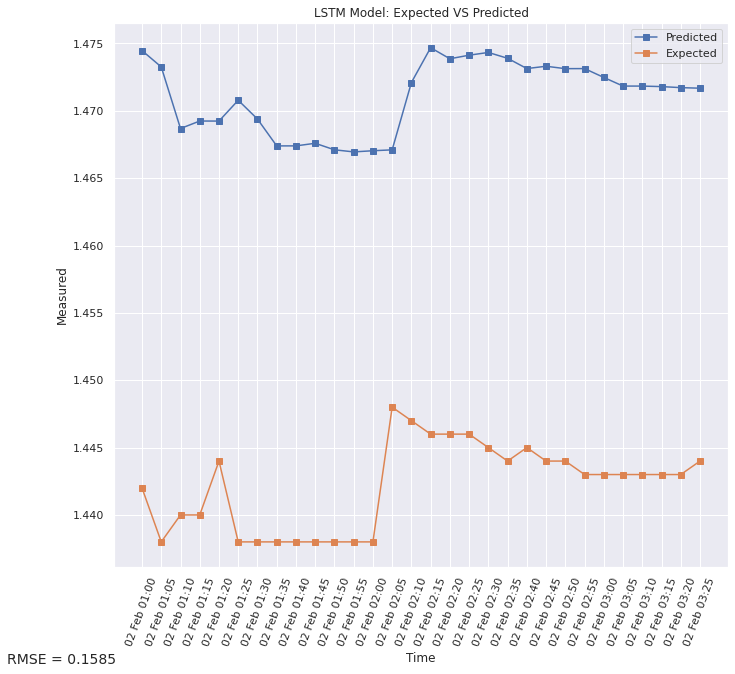

In [48]:
# Plot [start, end] interval
## 0 ~ 11824
start = 300
end = 330
plot_predicted_vs_expected(results["predicted"], results["expected"], results["overall_score"], date_interval.index, start, end)

## Scatter Plot

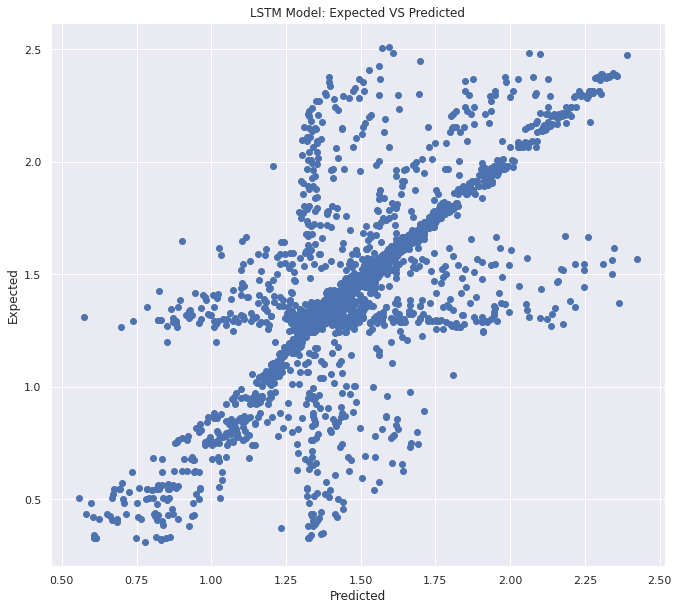

In [49]:
start = 0
end = -1
scatter_plot(results["predicted"], results["expected"], start, end)

## Main - Classification

## 7) S + SV + SD

In [87]:
# Read "Spike + Stationary Values + Sensor Displacement" data
anomaly_type = "s+sv+sd"

# ------------------------------------------------------------------ 

# Get test data (just data, without shifts)
df = input_data.reset_index()
df_slice = df[df.datetime.dt.date >= TEST_INIT_DATE] 
X_test = df_slice["measured"]
y_test = df_slice["label"]

test_set = {"data": X_test, "labels": y_test}
# ------------------------------------------------------------------

# Create and init the classifier
clf = Classifier()
clf.init()
clf.set_expected_classes(test_set["labels"])

# Calculates the MAPE
mape = np.mean(np.abs((results["expected"] - results["predicted"]) / results["expected"]))

# Calculates the MAPE
mape = get_MAPE(results["predicted"], results["expected"])

# Defines the limit
limit = mape * FACTOR
# print("\nLimit: {:.4}\n".format(limit))

# Make the classification and show the metrics
factors = [0.9, 10]
for factor in factors:
    limit = mape * factor
    
    print("\nLimit: {:.4}\n".format(limit))
    clf.get_classification(results["predicted"], limit, test_set["data"].tolist())
    metrics = clf.get_metrics(anomaly_type)


Limit: 0.0625

Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 689
    - TN: 6436
    - FP: 552
    - FN: 988
    - Hits: 7125
    - Misses: 1540
    - Total (hits + misses): 8665

  Metrics:
    - Accuracy: 82.23%
    - Precision: 55.52%
    - Recall: 41.09%
    - F1-Score: 47.22%

Limit: 0.6944

Spike (S) and Stationary Value (SV) and Sensor Displacement (SD):

  General:
    - TP: 121
    - TN: 6985
    - FP: 3
    - FN: 1556
    - Hits: 7106
    - Misses: 1559
    - Total (hits + misses): 8665

  Metrics:
    - Accuracy: 82.01%
    - Precision: 97.58%
    - Recall: 7.215%
    - F1-Score: 13.44%
